# Feature Engineering - Predicción de Precios de Aguacate

**Proyecto:** APEAJAL Avocado Forecasting  
**Objetivo:** Crear dataset con features para predicción de precios (horizonte: 1 mes)  
**Metodología:** CRISP-ML (Fase: Preparación de Datos)

---

## Índice
1. [Carga de Datos](#1-carga-de-datos)
2. [Consolidación y Merge](#2-consolidación-y-merge)
3. [Generación de Features](#3-generación-de-features)
4. [Transformaciones](#4-transformaciones)
5. [Codificación](#5-codificación)
6. [Escalamiento](#6-escalamiento)
7. [Selección de Features](#7-selección-de-features)
8. [Dataset Final](#8-dataset-final)
9. [Conclusiones CRISP-ML](#9-conclusiones-crisp-ml)

**Nombres y matrículas:**

  * José Antonio Gómez Mora | A01374459
  * Alejandro Chávez Campos | A01374974  
  * Laura Patricia Martínez Treviño | A01795967

**Número de Equipo:** 30

In [93]:
# Instalación de librerías (solo si es necesario en Colab)
# !pip install scikit-learn pandas numpy matplotlib seaborn scipy statsmodels

In [94]:
# Montar Google Drive (solo para Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print('Google Drive montado')
except:
    print('No estás en Colab, usando rutas locales')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive montado


In [95]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print("Librerías importadas")

Librerías importadas


## 1. Carga de Datos

**Justificación:** Cargamos todos los datasets limpios disponibles para crear un dataset consolidado con múltiples fuentes de información.

In [96]:
# Configurar rutas
try:
    from google.colab import drive
    # Si estamos en Colab, usar ruta de Drive
    BASE_PATH = '/content/drive/MyDrive/MNA/proyecto-integrador/clean/'
    OUTPUT_PATH = '/content/drive/MyDrive/MNA/proyecto-integrador/processed/'
except:
    # Si estamos en local, usar rutas relativas
    BASE_PATH = 'data/clean/'
    OUTPUT_PATH = 'data/processed/'

print(f'Ruta de datos: {BASE_PATH}')
print(f'Ruta de salida: {OUTPUT_PATH}')

# Cargar datasets
print("\nCargando datasets...")

# Target: Precios
precios = pd.read_csv(BASE_PATH + 'precios_mensuales_clean.csv', parse_dates=['date'])
print(f"Precios: {len(precios)} registros")

# Features: Oferta y Demanda
cosecha = pd.read_csv(BASE_PATH + 'mhaia_cosecha_semanal_clean.csv', parse_dates=['date'])
embarques = pd.read_csv(BASE_PATH + 'mhaia_embarques_semanal_clean.csv', parse_dates=['date'])
print(f"Cosecha: {len(cosecha)} registros")
print(f"Embarques: {len(embarques)} registros")

# Features: Importaciones EE.UU.
usitc = pd.read_csv(BASE_PATH + 'usitc_importaciones_clean.csv', parse_dates=['date'])
print(f"USITC: {len(usitc)} registros")

# Features: Tipo de cambio
tc = pd.read_csv(BASE_PATH + 'tipo_cambio_diario_clean.csv', parse_dates=['fecha'])
print(f"Tipo cambio: {len(tc)} registros")

# Features: Clima
clima = pd.read_csv(BASE_PATH + 'clima_jalisco_clean.csv', parse_dates=['date'])
print(f"Clima: {len(clima)} registros")

# Features: Exportaciones históricas
export_hist = pd.read_csv(BASE_PATH + 'exportaciones_historicas_clean.csv', parse_dates=['date'])
print(f"Exportaciones: {len(export_hist)} registros")

# Features: Producción histórica
prod_hist = pd.read_csv(BASE_PATH + 'produccion_historica_jalisco_clean.csv')
print(f"Producción histórica: {len(prod_hist)} registros")

print("\nTodos los datasets cargados")

Ruta de datos: /content/drive/MyDrive/MNA/proyecto-integrador/clean/
Ruta de salida: /content/drive/MyDrive/MNA/proyecto-integrador/processed/

Cargando datasets...
Precios: 1460 registros
Cosecha: 147 registros
Embarques: 147 registros
USITC: 46 registros
Tipo cambio: 1480 registros
Clima: 258 registros
Exportaciones: 132 registros
Producción histórica: 11 registros

Todos los datasets cargados


## 2. Consolidación y Merge

**Justificación:** Agregamos datos a granularidad mensual (target es mensual) y creamos un dataset consolidado con todas las variables.

**Decisiones:**
- Agregamos cosecha/embarques semanales a mensual (suma)
- Agregamos tipo de cambio diario a mensual (promedio)
- Filtramos clima solo para Jalisco (región de interés)
- Periodo común: 2015-2025 (máximo overlap de datos)

In [97]:
# 2.1 Preparar precios (target) - Consolidar 2015-2025
# Usar precio de exportación (2015-2021) + precio SNIIM (2022-2025)

# Precios SNIIM (2022-2025)
precios_sniim = precios.groupby('date')['price_avg'].mean().reset_index()
precios_sniim.columns = ['date', 'precio_promedio']
precios_sniim['source'] = 'sniim'

# Precios de exportación histórica (2015-2025) - convertir a MXN
# Necesitamos tipo de cambio para convertir USD a MXN
tc['date'] = pd.to_datetime(tc['fecha'])
tc_mensual_temp = tc.groupby(tc['date'].dt.to_period('M'))['tipo_cambio'].mean().reset_index()
tc_mensual_temp['date'] = tc_mensual_temp['date'].dt.to_timestamp()
tc_mensual_temp.columns = ['date', 'tipo_cambio']

# Precios de exportación en USD
precios_export = export_hist[['date', 'price_per_kg_usd']].copy()
precios_export = precios_export.merge(tc_mensual_temp, on='date', how='left')

# Convertir a MXN (usar TC promedio histórico si no hay dato)
tc_promedio = tc_mensual_temp['tipo_cambio'].mean()
precios_export['tipo_cambio'] = precios_export['tipo_cambio'].fillna(tc_promedio)
precios_export['precio_promedio'] = precios_export['price_per_kg_usd'] * precios_export['tipo_cambio']
precios_export = precios_export[['date', 'precio_promedio']]
precios_export['source'] = 'export_historico'

# Consolidar: usar SNIIM donde existe, exportaciones para el resto
precios_mensual = precios_export.copy()

# Sobrescribir con SNIIM (2022-2025)
for idx, row in precios_sniim.iterrows():
    mask = precios_mensual['date'] == row['date']
    if mask.any():
        precios_mensual.loc[mask, 'precio_promedio'] = row['precio_promedio']
        precios_mensual.loc[mask, 'source'] = 'sniim'
    else:
        precios_mensual = pd.concat([precios_mensual, pd.DataFrame([row])], ignore_index=True)

precios_mensual = precios_mensual.sort_values('date').reset_index(drop=True)
precios_mensual = precios_mensual[['date', 'precio_promedio']]

print(f"Precios consolidados: {len(precios_mensual)} registros")
print(f"   Periodo: {precios_mensual['date'].min().date()} a {precios_mensual['date'].max().date()}")
print(f"   2015-2021: Precio exportación (USD→MXN)")
print(f"   2022-2025: Precio SNIIM (MXN)")

Precios consolidados: 180 registros
   Periodo: 2015-01-01 a 2026-01-15
   2015-2021: Precio exportación (USD→MXN)
   2022-2025: Precio SNIIM (MXN)


In [98]:
# 2.2 Agregar cosecha a mensual
cosecha['year_month'] = cosecha['date'].dt.to_period('M')
cosecha_mensual = cosecha.groupby('year_month').agg({
    'harvest_tons_actual': 'sum',
    'harvest_tons_projected': 'sum'
}).reset_index()
cosecha_mensual['date'] = cosecha_mensual['year_month'].dt.to_timestamp()
cosecha_mensual = cosecha_mensual[['date', 'harvest_tons_actual', 'harvest_tons_projected']]
cosecha_mensual.columns = ['date', 'cosecha_tons', 'cosecha_proyectada_tons']
print(f"\nCosecha mensual: {len(cosecha_mensual)} registros")


Cosecha mensual: 34 registros


In [99]:
# 2.3 Agregar embarques a mensual
embarques['year_month'] = embarques['date'].dt.to_period('M')
embarques_mensual = embarques.groupby('year_month')['shipment_tons_actual'].sum().reset_index()
embarques_mensual.columns = ['year_month', 'embarques_tons']
embarques_mensual['date'] = embarques_mensual['year_month'].dt.to_timestamp()
embarques_mensual = embarques_mensual[['date', 'embarques_tons']]
print(f"Embarques mensual: {len(embarques_mensual)} registros")

Embarques mensual: 34 registros


In [100]:
# 2.4 Agregar tipo de cambio a mensual
tc['date'] = pd.to_datetime(tc['fecha'])
tc['year_month'] = tc['date'].dt.to_period('M')
tc_mensual = tc.groupby('year_month')['tipo_cambio'].mean().reset_index()
tc_mensual['date'] = tc_mensual['year_month'].dt.to_timestamp()
tc_mensual = tc_mensual[['date', 'tipo_cambio']]
print(f"Tipo cambio mensual: {len(tc_mensual)} registros")

Tipo cambio mensual: 49 registros


In [101]:
# 2.5 Filtrar clima solo Jalisco
clima_jalisco = clima[clima['state'] == 'Jalisco'][['date', 'temp_min_c', 'temp_avg_c', 'temp_max_c', 'precipitation_mm']].copy()
print(f"Clima Jalisco: {len(clima_jalisco)} registros")

Clima Jalisco: 129 registros


In [102]:
# 2.6 Consolidar importaciones/exportaciones (2015-2025)
# Usar exportaciones históricas (2015-2025) y complementar con USITC (2022-2025)

# Preparar exportaciones históricas
export_prep = export_hist[['date', 'quantity_kg', 'price_per_kg_usd']].copy()
export_prep.columns = ['date', 'importaciones_kg', 'precio_importacion_usd']

# Preparar USITC
usitc_prep = usitc[['date', 'quantity_kg', 'price_per_kg_usd']].copy()
usitc_prep.columns = ['date', 'importaciones_kg', 'precio_importacion_usd']

# Consolidar: usar USITC donde existe, exportaciones históricas para el resto
import_export = export_prep.copy()

# Actualizar con datos de USITC (sobrescribir 2022-2025)
for idx, row in usitc_prep.iterrows():
    mask = import_export['date'] == row['date']
    if mask.any():
        import_export.loc[mask, 'importaciones_kg'] = row['importaciones_kg']
        import_export.loc[mask, 'precio_importacion_usd'] = row['precio_importacion_usd']
    else:
        import_export = pd.concat([import_export, pd.DataFrame([row])], ignore_index=True)

import_export = import_export.sort_values('date').reset_index(drop=True)

print(f"Importaciones/Exportaciones consolidadas: {len(import_export)} registros")
print(f"Periodo: {import_export['date'].min().date()} a {import_export['date'].max().date()}")

Importaciones/Exportaciones consolidadas: 132 registros
Periodo: 2015-01-01 a 2025-12-01


In [103]:
# 2.8 Merge de todos los datasets
print("Consolidando datasets...\n")

# Empezar con precios (target)
df = precios_mensual.copy()
print(f"Base (precios): {len(df)} registros")

# Merge con cosecha
df = df.merge(cosecha_mensual, on='date', how='left')
print(f"+ Cosecha: {len(df)} registros")

# Merge con embarques
df = df.merge(embarques_mensual, on='date', how='left')
print(f"+ Embarques: {len(df)} registros")

# Merge con tipo de cambio
df = df.merge(tc_mensual, on='date', how='left')
print(f"+ Tipo cambio: {len(df)} registros")

# Merge con clima
df = df.merge(clima_jalisco, on='date', how='left')
print(f"+ Clima: {len(df)} registros")

# Merge con importaciones/exportaciones consolidadas
df = df.merge(import_export, on='date', how='left')
print(f"+ Importaciones/Exportaciones: {len(df)} registros")


print(f"\nDataset consolidado: {df.shape}")
print(f"Periodo: {df['date'].min().date()} a {df['date'].max().date()}")

Consolidando datasets...

Base (precios): 180 registros
+ Cosecha: 180 registros
+ Embarques: 180 registros
+ Tipo cambio: 180 registros
+ Clima: 180 registros
+ Importaciones/Exportaciones: 180 registros

Dataset consolidado: (180, 12)
Periodo: 2015-01-01 a 2026-01-15


In [104]:
# Visualizar primeras filas
df.head()

,date,precio_promedio,cosecha_tons,cosecha_proyectada_tons,embarques_tons,tipo_cambio,temp_min_c,temp_avg_c,temp_max_c,precipitation_mm,importaciones_kg,precio_importacion_usd
0,2015-01-01,38.066697,NaN,NaN,NaN,NaN,8.9,17.5,26.1,6.5,82796666.0,2.022103
1,2015-02-01,38.429360,NaN,NaN,NaN,NaN,9.3,17.9,26.5,42.2,58970191.0,2.041368
2,2015-03-01,40.374530,NaN,NaN,NaN,NaN,10.8,19.3,27.9,140.2,65480365.0,2.144695
3,2015-04-01,40.885613,NaN,NaN,NaN,NaN,13.6,21.9,30.3,7.3,58629937.0,2.171844
4,2015-05-01,39.111396,NaN,NaN,NaN,NaN,14.9,23.3,31.7,42.7,60720230.0,2.077597


In [105]:
# Información del dataset
print("Información del dataset consolidado:\n")
df.info()
print(f"\nValores nulos por columna:\n{df.isnull().sum()}")

Información del dataset consolidado:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     180 non-null    datetime64[ns]
 1   precio_promedio          178 non-null    float64       
 2   cosecha_tons             28 non-null     float64       
 3   cosecha_proyectada_tons  28 non-null     float64       
 4   embarques_tons           28 non-null     float64       
 5   tipo_cambio              48 non-null     float64       
 6   temp_min_c               129 non-null    float64       
 7   temp_avg_c               129 non-null    float64       
 8   temp_max_c               129 non-null    float64       
 9   precipitation_mm         129 non-null    float64       
 10  importaciones_kg         130 non-null    float64       
 11  precio_importacion_usd   130 non-null    float64       
dty

## 3. Generación de Features

**Justificación:** Creamos features derivadas que capturan patrones temporales, relaciones entre variables y estacionalidad.

### 3.1 Features Temporales (Estacionalidad)
**Decisión:** El aguacate tiene estacionalidad clara (4 temporadas de cosecha). Extraemos mes, trimestre y temporada.

In [106]:
# 3.1 Features temporales
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter

# Temporada de cosecha (basado en calendario agrícola)
def get_temporada(month):
    if month in [7, 8, 9]:
        return 'loca'  # Julio-Sept
    elif month in [10, 11, 12]:
        return 'aventajada'  # Oct-Dic
    elif month in [1, 2, 3]:
        return 'normal'  # Ene-Mar
    else:
        return 'marcena'  # Abr-Jun

df['temporada'] = df['month'].apply(get_temporada)

print("Features temporales creadas: year, month, quarter, temporada")

Features temporales creadas: year, month, quarter, temporada


### 3.2.1 Funciones de autocorrelación ACF/PACF

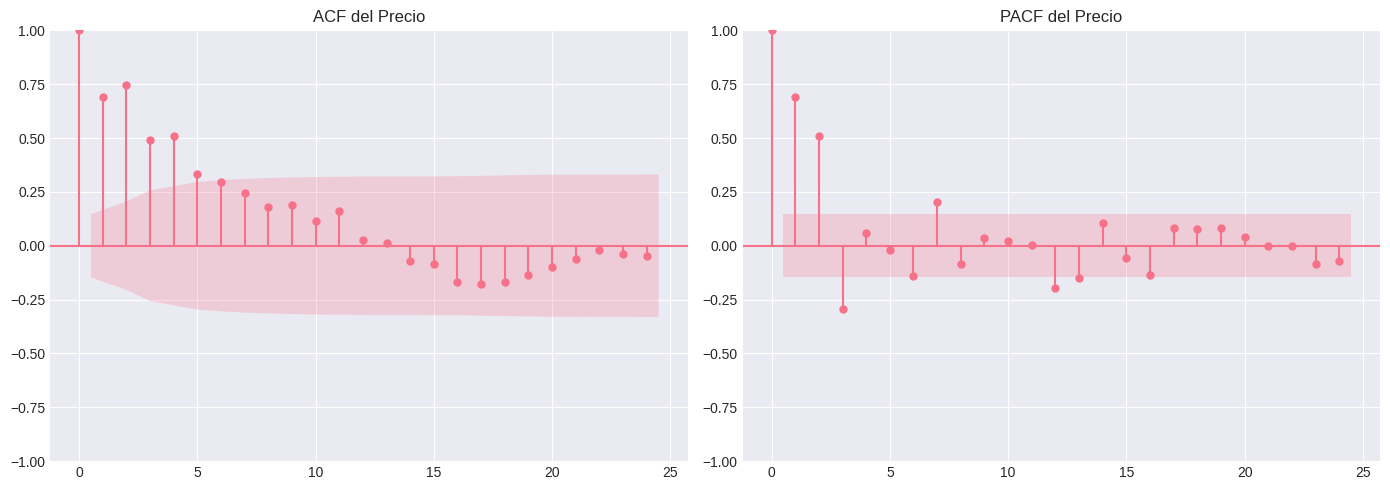

In [107]:
df = df.sort_values('date')
# Serie de precios (sin NA)
precio = df.set_index('date')['precio_promedio'].dropna()

fig, axes = plt.subplots(1, 2, figsize=(14,5))
plot_acf(precio, lags=24, ax=axes[0])
axes[0].set_title('ACF del Precio')

plot_pacf(precio, lags=24, ax=axes[1], method='ywm')
axes[1].set_title('PACF del Precio')

plt.tight_layout()
plt.show()

*   Función de autocorrelación (ACF) El precio del aguacate presenta alta presencia temporal.
*   Función de autocorrelación (PACF) La dinámica del precio puede explicarse principalmente por los tres meses previos.

### 3.2.2 Features de Lags
**Decisión:** Precios pasados son predictores importantes. Usamos lags de 1, 2, 3 meses.

In [108]:
# 3.2 Lags de precio (1, 2, 3 meses)
df = df.sort_values('date')
df['precio_lag1'] = df['precio_promedio'].shift(1)
df['precio_lag2'] = df['precio_promedio'].shift(2)
df['precio_lag3'] = df['precio_promedio'].shift(3)

print("Lags de precio creados: lag1, lag2, lag3")

Lags de precio creados: lag1, lag2, lag3


### 3.3 Features de Rolling Windows
**Decisión:** Medias móviles capturan tendencias. Usamos ventanas de 3, 6, 12 meses.
*   Media móvil 3 meses: Captura shocks recientes, ajustes rápidos del mercado, comportamiento inercial.
*   Media móvil 6 meses: Captura transición entre temporadas, ajustes graduales de oferta/demanda, persistencia de shocks.
*   Media móvil 12 meses: Ciclo anual agrícola, nivel "normal" del mercado, estacionalidad estructural.

In [109]:
# 3.3 Medias móviles (3, 6, 12 meses)
df['precio_ma3'] = df['precio_promedio'].rolling(window=3, min_periods=1).mean()
df['precio_ma6'] = df['precio_promedio'].rolling(window=6, min_periods=1).mean()
df['precio_ma12'] = df['precio_promedio'].rolling(window=12, min_periods=1).mean()

# Desviación estándar móvil (volatilidad)
df['precio_std3'] = df['precio_promedio'].rolling(window=3, min_periods=1).std()

print("Rolling features creados: ma3, ma6, ma12, std3")

Rolling features creados: ma3, ma6, ma12, std3


### 3.4 Features de Ratios
**Decisión:** Ratios capturan relaciones entre variables (oferta/demanda, precios relativos).

In [110]:
# 3.4 Ratios
# Ratio oferta/demanda
df['ratio_oferta_demanda'] = df['cosecha_tons'] / (df['embarques_tons'] + 1)  # +1 para evitar división por 0

# Diferencia oferta-demanda (balance)
df['balance_oferta_demanda'] = df['cosecha_tons'] - df['embarques_tons']

# Precio México vs EE.UU. (en MXN)
df['precio_importacion_mxn'] = df['precio_importacion_usd'] * df['tipo_cambio']
df['diferencial_precio_mx_us'] = df['precio_promedio'] - df['precio_importacion_mxn']

print("Ratios creados: ratio_oferta_demanda, balance, diferencial_precio")

Ratios creados: ratio_oferta_demanda, balance, diferencial_precio


### 3.5 Features de Interacción
**Decisión:** Interacciones capturan efectos combinados (ej: temperatura × precipitación).

In [111]:
# 3.5 Interacciones climáticas
df['temp_precip_interaction'] = df['temp_avg_c'] * df['precipitation_mm']

# Interacción estacionalidad × oferta
df['cosecha_por_mes'] = df['cosecha_tons'] * df['month']

print("Interacciones creadas")

Interacciones creadas


### 3.6 Variable Target
**Decisión:** Target es el precio del próximo mes (horizonte: 1 mes).

In [112]:
# 3.6 Crear target (precio próximo mes)
df['precio_proximo_mes'] = df['precio_promedio'].shift(-1)

print("Target creado: precio_proximo_mes")
print(f"\nDataset con features: {df.shape}")
print(f"Columnas: {list(df.columns)}")

Target creado: precio_proximo_mes

Dataset con features: (180, 30)
Columnas: ['date', 'precio_promedio', 'cosecha_tons', 'cosecha_proyectada_tons', 'embarques_tons', 'tipo_cambio', 'temp_min_c', 'temp_avg_c', 'temp_max_c', 'precipitation_mm', 'importaciones_kg', 'precio_importacion_usd', 'year', 'month', 'quarter', 'temporada', 'precio_lag1', 'precio_lag2', 'precio_lag3', 'precio_ma3', 'precio_ma6', 'precio_ma12', 'precio_std3', 'ratio_oferta_demanda', 'balance_oferta_demanda', 'precio_importacion_mxn', 'diferencial_precio_mx_us', 'temp_precip_interaction', 'cosecha_por_mes', 'precio_proximo_mes']


## 4. Transformaciones

**Justificación:** Transformaciones normalizan distribuciones y estabilizan varianza.

### 4.1 Análisis de Distribuciones

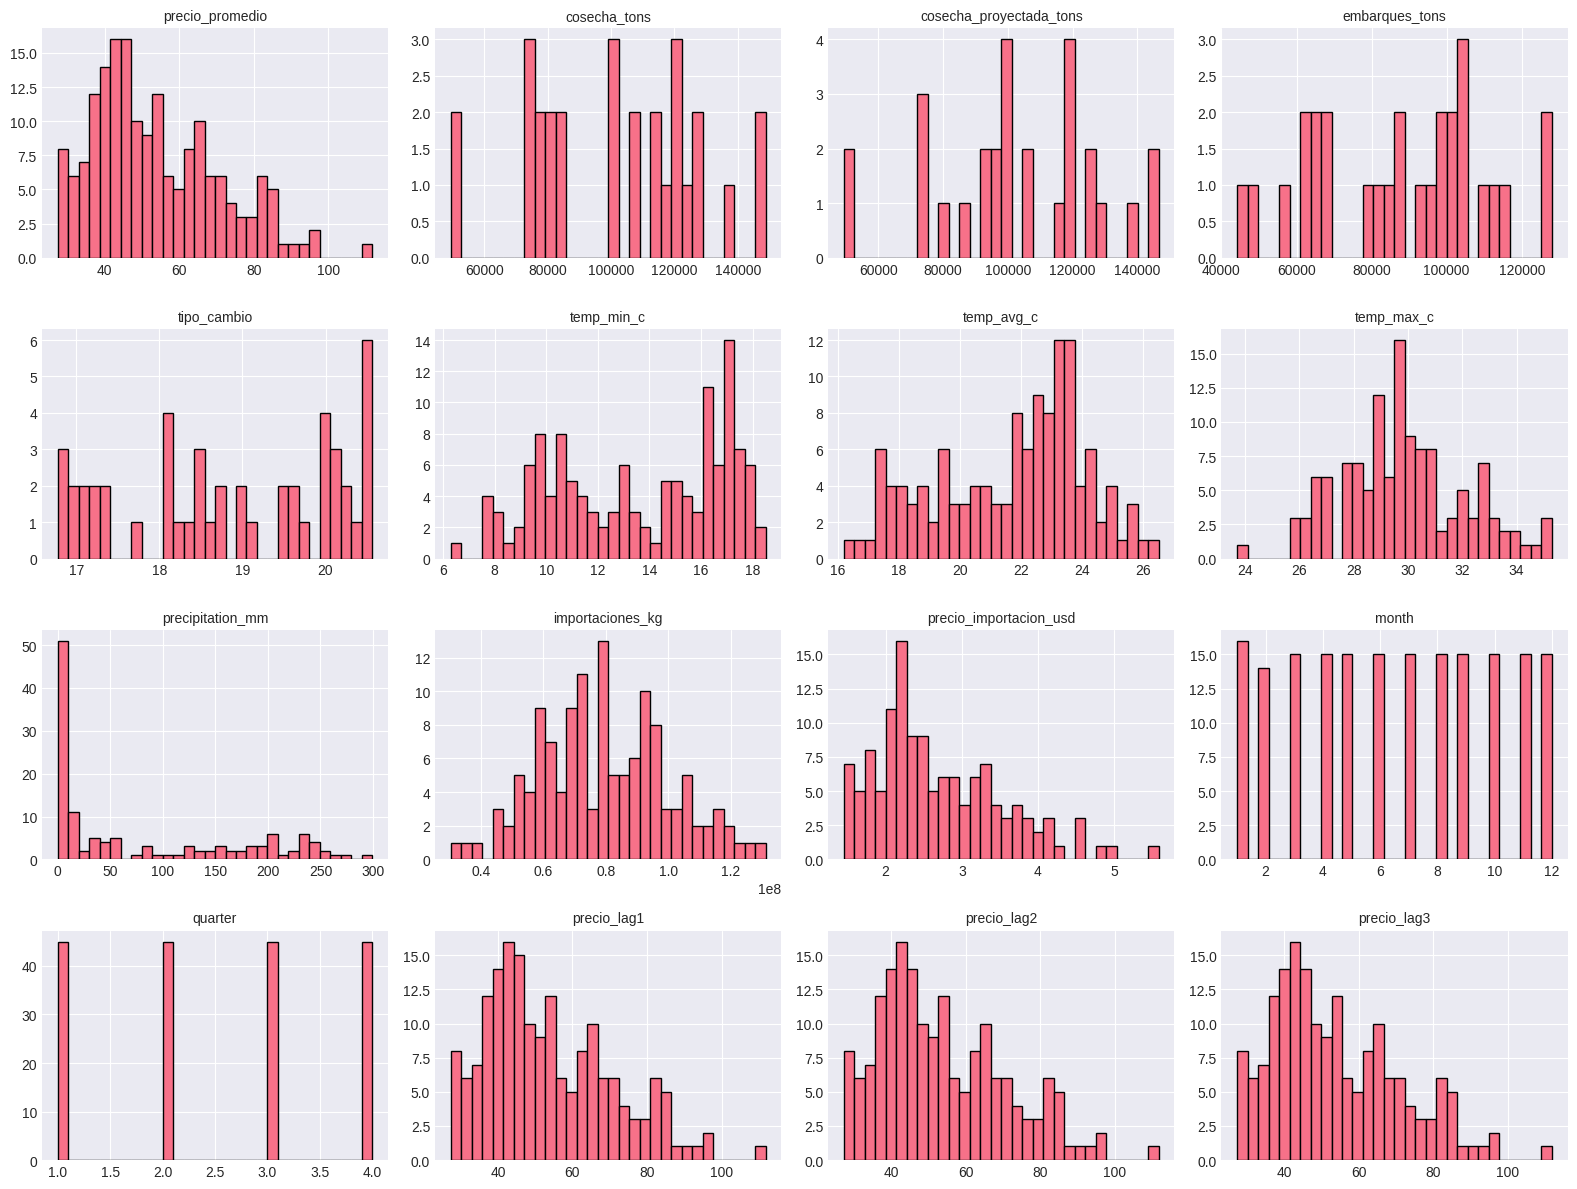


Distribuciones visualizadas: 16 variables


In [113]:
# 4.1 Visualizar distribuciones de variables numéricas
# Usar df (dataset consolidado con features generadas)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Excluir columnas de fecha y target
numeric_cols = [col for col in numeric_cols if col not in ['year', 'precio_proximo_mes']]

# Limitar a primeras 16 columnas para visualización
cols_to_plot = numeric_cols[:16]

fig, axes = plt.subplots(4, 4, figsize=(16, 12))
axes = axes.ravel()

for i, col in enumerate(cols_to_plot):
    if i < len(axes):
        df[col].hist(bins=30, ax=axes[i], edgecolor='black')
        axes[i].set_title(col, fontsize=10)
        axes[i].set_xlabel('')

# Ocultar ejes vacíos
for i in range(len(cols_to_plot), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

print(f"\nDistribuciones visualizadas: {len(cols_to_plot)} variables")

### 4.2 Transformación Logarítmica
**Decisión:** Aplicamos log a variables con distribución sesgada (precios, volúmenes).

In [114]:
# 4.2 Transformación logarítmica
# Variables candidatas: precios, volúmenes
log_cols = ['precio_promedio', 'cosecha_tons', 'embarques_tons', 'importaciones_kg', 'exportaciones_kg']

for col in log_cols:
    if col in df.columns:
        # Log(x + 1) para manejar ceros
        df[f'{col}_log'] = np.log1p(df[col].fillna(0))

print(f"Transformación log aplicada a {len(log_cols)} variables")

Transformación log aplicada a 5 variables


### 4.3 Transformación Box-Cox
**Decisión:** Box-Cox normaliza distribuciones automáticamente (solo para valores positivos).

In [115]:
# 4.3 Box-Cox (solo para variables sin valores negativos o cero)
from sklearn.preprocessing import PowerTransformer

# Usar Yeo-Johnson (maneja negativos y ceros)
pt = PowerTransformer(method='yeo-johnson', standardize=False)

boxcox_cols = ['precio_promedio', 'tipo_cambio', 'temp_avg_c']
for col in boxcox_cols:
    if col in df.columns:
        valid_data = df[col].dropna()
        if len(valid_data) > 0:
            df[f'{col}_boxcox'] = np.nan
            df.loc[df[col].notna(), f'{col}_boxcox'] = pt.fit_transform(df[col].dropna().values.reshape(-1, 1)).ravel()

print(f"Transformación Box-Cox/Yeo-Johnson aplicada a {len(boxcox_cols)} variables")

Transformación Box-Cox/Yeo-Johnson aplicada a 3 variables


### 4.4 Comparación Antes/Después de Transformaciones
**Visualización:** Comparar distribuciones originales vs transformadas.

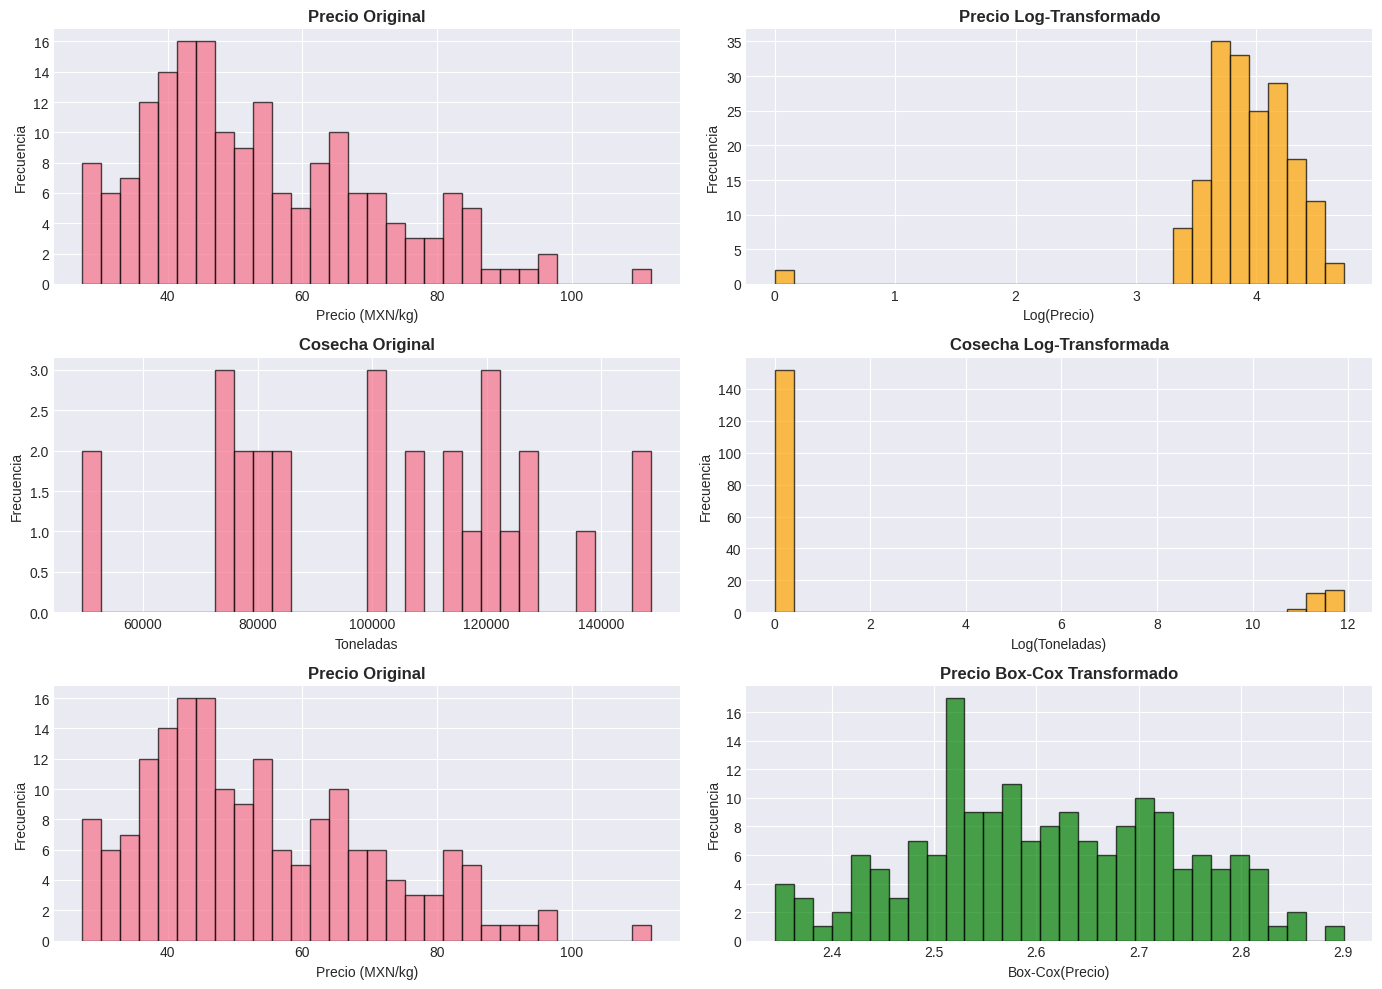


Comparación visual: Las transformaciones normalizan las distribuciones sesgadas


In [116]:
# 4.4 Visualización comparativa de transformaciones
fig, axes = plt.subplots(3, 2, figsize=(14, 10))

# Precio: Original vs Log
axes[0, 0].hist(df['precio_promedio'].dropna(), bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Precio Original', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Precio (MXN/kg)')
axes[0, 0].set_ylabel('Frecuencia')

axes[0, 1].hist(df['precio_promedio_log'].dropna(), bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_title('Precio Log-Transformado', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Log(Precio)')
axes[0, 1].set_ylabel('Frecuencia')

# Cosecha: Original vs Log
axes[1, 0].hist(df['cosecha_tons'].dropna(), bins=30, edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Cosecha Original', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Toneladas')
axes[1, 0].set_ylabel('Frecuencia')

axes[1, 1].hist(df['cosecha_tons_log'].dropna(), bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1, 1].set_title('Cosecha Log-Transformada', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Log(Toneladas)')
axes[1, 1].set_ylabel('Frecuencia')

# Precio: Original vs Box-Cox
axes[2, 0].hist(df['precio_promedio'].dropna(), bins=30, edgecolor='black', alpha=0.7)
axes[2, 0].set_title('Precio Original', fontsize=12, fontweight='bold')
axes[2, 0].set_xlabel('Precio (MXN/kg)')
axes[2, 0].set_ylabel('Frecuencia')

axes[2, 1].hist(df['precio_promedio_boxcox'].dropna(), bins=30, edgecolor='black', alpha=0.7, color='green')
axes[2, 1].set_title('Precio Box-Cox Transformado', fontsize=12, fontweight='bold')
axes[2, 1].set_xlabel('Box-Cox(Precio)')
axes[2, 1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

print("\nComparación visual: Las transformaciones normalizan las distribuciones sesgadas")

In [117]:
# Test de normalidad (Shapiro-Wilk)
from scipy.stats import shapiro

print("Test de Normalidad (Shapiro-Wilk):")
print("H0: La distribución es normal (p > 0.05)\n")

# Precio original
stat_orig, p_orig = shapiro(df['precio_promedio'].dropna())
print(f"Precio Original: p-value = {p_orig:.6f} {'NORMAL' if p_orig > 0.05 else 'No NORMAL'}")

# Precio log
stat_log, p_log = shapiro(df['precio_promedio_log'].dropna())
print(f"Precio Log: p-value = {p_log:.6f} {'NORMAL' if p_log > 0.05 else 'No NORMAL'}")

# Precio Box-Cox
stat_bc, p_bc = shapiro(df['precio_promedio_boxcox'].dropna())
print(f"Precio Box-Cox: p-value = {p_bc:.6f} {'NORMAL' if p_bc > 0.05 else 'No NORMAL'}")

print("\nInterpretación: Transformaciones mejoran la normalidad de las distribuciones")

Test de Normalidad (Shapiro-Wilk):
H0: La distribución es normal (p > 0.05)

Precio Original: p-value = 0.000005 No NORMAL
Precio Log: p-value = 0.000000 No NORMAL
Precio Box-Cox: p-value = 0.064472 NORMAL

Interpretación: Transformaciones mejoran la normalidad de las distribuciones


## 5. Codificación

**Justificación:** Convertimos variables categóricas en numéricas para modelos ML.

### 5.1 One-Hot Encoding
**Decisión:** Temporada es categórica nominal (sin orden) → One-Hot Encoding.

In [118]:
# 5.1 One-Hot Encoding para temporada
df_encoded = pd.get_dummies(df, columns=['temporada'], prefix='temp', drop_first=True)

print(f"One-Hot Encoding aplicado")
print(f"Nuevas columnas: {[col for col in df_encoded.columns if 'temp_' in col]}")
print(f"Shape: {df_encoded.shape}")

One-Hot Encoding aplicado
Nuevas columnas: ['temp_min_c', 'temp_avg_c', 'temp_max_c', 'temp_precip_interaction', 'temp_avg_c_boxcox', 'temp_loca', 'temp_marcena', 'temp_normal']
Shape: (180, 39)


### 5.2 Codificación Cíclica
**Decisión:** Mes es cíclico (diciembre → enero) → Codificación sin/cos.

In [119]:
# 5.2 Codificación cíclica para mes
df_encoded['month_sin'] = np.sin(2 * np.pi * df_encoded['month'] / 12)
df_encoded['month_cos'] = np.cos(2 * np.pi * df_encoded['month'] / 12)

print("Codificación cíclica aplicada a mes")

Codificación cíclica aplicada a mes


## 6. Escalamiento

**Justificación:** Escalamiento normaliza rangos de variables para algoritmos sensibles a escala.

### 6.1 Preparar datos para escalamiento

In [120]:
# 6.1 Eliminar filas con target nulo (última fila)
df_model = df_encoded[df_encoded['precio_proximo_mes'].notna()].copy()

# Eliminar columnas no necesarias
cols_to_drop = ['date', 'precio_proximo_mes']  # Guardaremos target aparte
X = df_model.drop(columns=cols_to_drop, errors='ignore')
y = df_model['precio_proximo_mes']

print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"\nColumnas en X: {len(X.columns)}")

Features (X): (177, 39)
Target (y): (177,)

Columnas en X: 39


In [121]:
# Manejar valores nulos
print(f"Valores nulos antes de imputación:\n{X.isnull().sum().sum()} total")
print(f"\nColumnas con >50% nulos:")
null_pct = (X.isnull().sum() / len(X) * 100).sort_values(ascending=False)
print(null_pct[null_pct > 50].head(10))

# Eliminar columnas con >80% nulos (no aportan información)
cols_to_drop = null_pct[null_pct > 80].index.tolist()
if cols_to_drop:
    print(f"\nEliminando {len(cols_to_drop)} columnas con >80% nulos: {cols_to_drop}")
    X = X.drop(columns=cols_to_drop)

# Imputar con mediana (robusto a outliers)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
X_filled = pd.DataFrame(
    imputer.fit_transform(X),
    columns=X.columns,
    index=X.index
)

print(f"\nValores nulos después de imputación: {X_filled.isnull().sum().sum()}")
print(f"Features finales: {X_filled.shape[1]}")

Valores nulos antes de imputación:
1811 total

Columnas con >50% nulos:
cosecha_tons                84.180791
cosecha_proyectada_tons     84.180791
embarques_tons              84.180791
ratio_oferta_demanda        84.180791
cosecha_por_mes             84.180791
balance_oferta_demanda      84.180791
precio_importacion_mxn      74.011299
diferencial_precio_mx_us    74.011299
tipo_cambio_boxcox          72.881356
tipo_cambio                 72.881356
dtype: float64

Eliminando 6 columnas con >80% nulos: ['cosecha_tons', 'cosecha_proyectada_tons', 'embarques_tons', 'ratio_oferta_demanda', 'cosecha_por_mes', 'balance_oferta_demanda']

Valores nulos después de imputación: 0
Features finales: 33


### 6.2 StandardScaler
**Decisión:** Estandarización (media=0, std=1) para algoritmos como SVM, KNN, Redes Neuronales.

In [122]:
# 6.2 StandardScaler
from sklearn.preprocessing import StandardScaler

scaler_std = StandardScaler()
X_scaled_std = pd.DataFrame(
    scaler_std.fit_transform(X_filled),
    columns=X_filled.columns,
    index=X_filled.index
)

print("StandardScaler aplicado")
print(f"Media: {X_scaled_std.mean().mean():.6f}")
print(f"Std: {X_scaled_std.std().mean():.6f}")

StandardScaler aplicado
Media: 0.000000
Std: 0.972448


### 6.3 MinMaxScaler
**Decisión:** Normalización [0,1] para algoritmos como Redes Neuronales con activación sigmoide.

In [123]:
# 6.3 MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler_minmax = MinMaxScaler()
X_scaled_minmax = pd.DataFrame(
    scaler_minmax.fit_transform(X_filled),
    columns=X_filled.columns,
    index=X_filled.index
)

print("MinMaxScaler aplicado")
print(f"Min: {X_scaled_minmax.min().min():.6f}")
print(f"Max: {X_scaled_minmax.max().max():.6f}")

MinMaxScaler aplicado
Min: 0.000000
Max: 1.000000


## 7. Selección de Features

**Justificación:** Reducir dimensionalidad mejora performance y evita overfitting.

### 7.1 Umbral de Varianza
**Decisión:** Eliminar features con varianza casi cero (no aportan información).

In [124]:
# 7.1 Variance Threshold
from sklearn.feature_selection import VarianceThreshold

# Umbral: 0.01 (eliminar features con varianza < 1%)
selector_var = VarianceThreshold(threshold=0.01)
X_var = selector_var.fit_transform(X_scaled_std)

features_removed = X_scaled_std.columns[~selector_var.get_support()].tolist()
print(f"Features eliminadas por baja varianza ({len(features_removed)}): {features_removed}")
print(f"Features restantes: {X_var.shape[1]}")

Features eliminadas por baja varianza (1): ['diferencial_precio_mx_us']
Features restantes: 32


### 7.2 Correlación con Target
**Decisión:** Identificar features más correlacionadas con precio futuro.

Top 15 features por correlación con target:

precio_lag1               0.748717
precio_ma3                0.719653
precio_promedio_boxcox    0.711030
precio_promedio           0.693053
precio_ma6                0.627515
precio_importacion_usd    0.587799
precio_lag3               0.514977
precio_lag2               0.496216
precio_ma12               0.489675
precio_promedio_log       0.447960
year                      0.392183
month_cos                 0.383258
temp_avg_c                0.377698
temp_avg_c_boxcox         0.374747
precio_importacion_mxn    0.373135
dtype: float64


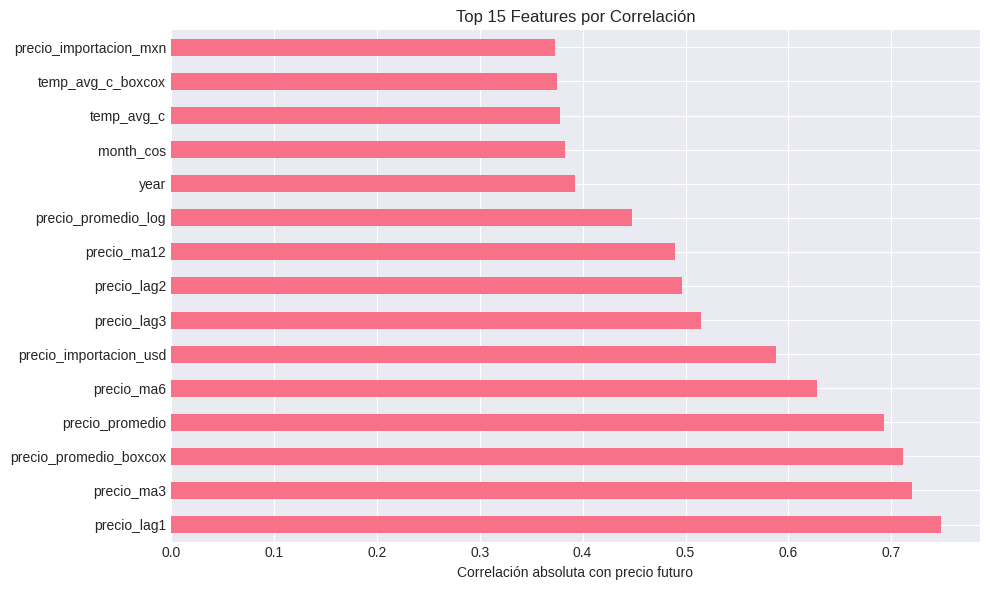

In [125]:
# 7.2 Correlación con target
correlations = X_filled.corrwith(y).abs().sort_values(ascending=False)

print("Top 15 features por correlación con target:\n")
print(correlations.head(15))

# Visualizar
plt.figure(figsize=(10, 6))
correlations.head(15).plot(kind='barh')
plt.xlabel('Correlación absoluta con precio futuro')
plt.title('Top 15 Features por Correlación')
plt.tight_layout()
plt.show()

### 7.3 Matriz de Correlación
**Decisión:** Identificar multicolinealidad (features redundantes).

In [126]:
# 7.3 Matriz de correlación entre features
corr_matrix = X_filled.corr()

# Encontrar pares altamente correlacionados (>0.9)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

print(f"\nPares de features con correlación > 0.9 ({len(high_corr_pairs)}):")
for feat1, feat2, corr in high_corr_pairs[:10]:
    print(f"  {feat1} <-> {feat2}: {corr:.3f}")


Pares de features con correlación > 0.9 (11):
  precio_promedio <-> precio_ma3: 0.906
  precio_promedio <-> precio_promedio_boxcox: 0.979
  tipo_cambio <-> tipo_cambio_boxcox: 0.997
  temp_min_c <-> temp_avg_c: 0.912
  temp_min_c <-> temp_avg_c_boxcox: 0.905
  temp_avg_c <-> temp_avg_c_boxcox: 0.995
  precipitation_mm <-> temp_precip_interaction: 0.999
  month <-> quarter: 0.971
  precio_lag2 <-> precio_ma3: 0.905
  precio_ma3 <-> precio_ma6: 0.921


### 7.4 SelectKBest (ANOVA F-test)
**Decisión:** Seleccionar top K features usando test estadístico.

In [127]:
# 7.4 SelectKBest con F-regression
from sklearn.feature_selection import SelectKBest, f_regression

k_best = 20  # Seleccionar top 20 features
selector_kbest = SelectKBest(score_func=f_regression, k=k_best)
X_kbest = selector_kbest.fit_transform(X_filled, y)

# Features seleccionadas
selected_features = X_filled.columns[selector_kbest.get_support()].tolist()
print(f"\nTop {k_best} features seleccionadas por F-test:\n")
for i, feat in enumerate(selected_features, 1):
    print(f"{i}. {feat}")

# Crear DataFrame con features seleccionadas (para VIF)
X_final_kbest = pd.DataFrame(
    X_kbest,
    columns=selected_features,
    index=X_filled.index
)
print(f"\nDataset con SelectKBest: {X_final_kbest.shape}")


Top 20 features seleccionadas por F-test:

1. precio_promedio
2. temp_min_c
3. temp_avg_c
4. temp_max_c
5. precio_importacion_usd
6. year
7. precio_lag1
8. precio_lag2
9. precio_lag3
10. precio_ma3
11. precio_ma6
12. precio_ma12
13. precio_std3
14. precio_importacion_mxn
15. precio_promedio_log
16. cosecha_tons_log
17. embarques_tons_log
18. precio_promedio_boxcox
19. temp_avg_c_boxcox
20. month_cos

Dataset con SelectKBest: (177, 20)


### 7.5 PCA (Análisis de Componentes Principales)
**Decisión:** Reducir dimensionalidad preservando 95% de varianza.

PCA aplicado
Componentes originales: 33
Componentes PCA: 13
Varianza explicada: 96.00%


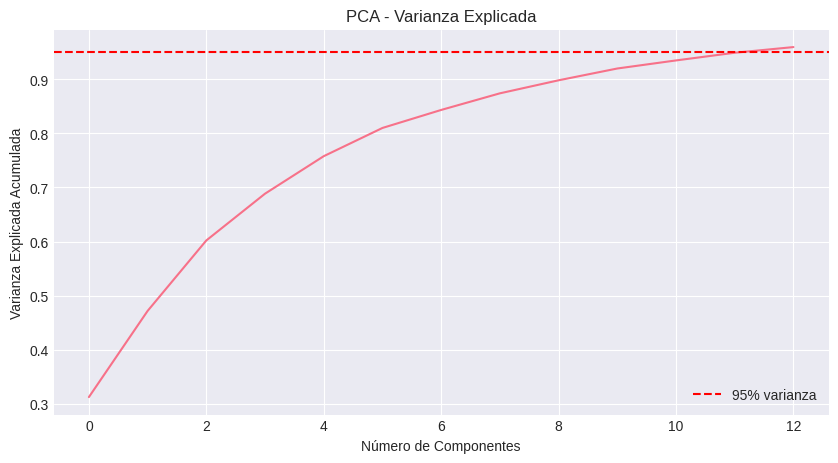

In [128]:
# 7.5 PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)  # Preservar 95% de varianza
X_pca = pca.fit_transform(X_scaled_std)

print(f"PCA aplicado")
print(f"Componentes originales: {X_scaled_std.shape[1]}")
print(f"Componentes PCA: {X_pca.shape[1]}")
print(f"Varianza explicada: {pca.explained_variance_ratio_.sum():.2%}")

# Visualizar varianza explicada
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('PCA - Varianza Explicada')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% varianza')
plt.legend()
plt.show()

### 7.6 Tabla Resumen de Técnicas de Selección
**Comparación:** Resultados de diferentes métodos de selección.


RESUMEN DE TÉCNICAS DE SELECCIÓN/EXTRACCIÓN
             Técnica  Features  Reducción (%) Interpretabilidad                             Uso Recomendado
    Dataset Original        33            0.0              Alta                                    Baseline
  Variance Threshold        32            3.0              Alta                                Pre-filtrado
SelectKBest (F-test)        20           39.4              Alta Modelos interpretables (Regresión, Árboles)
  PCA (95% varianza)        13           60.6              Baja                       Redes Neuronales, SVM


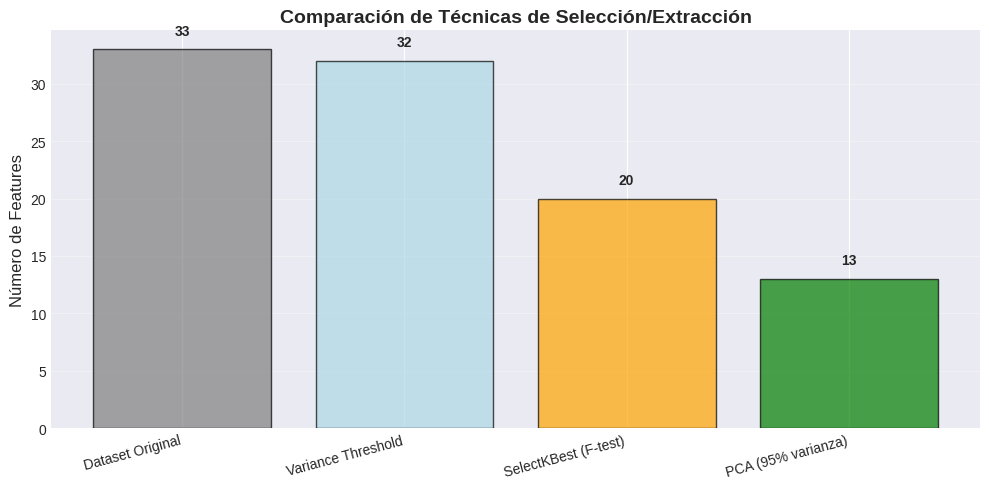


Conclusión: SelectKBest ofrece el mejor balance entre reducción e interpretabilidad


In [129]:
# 7.6 Tabla resumen de técnicas
import pandas as pd

resumen_tecnicas = pd.DataFrame({
    'Técnica': [
        'Dataset Original',
        'Variance Threshold',
        'SelectKBest (F-test)',
        'PCA (95% varianza)'
    ],
    'Features': [
        X_filled.shape[1],
        X_var.shape[1],
        len(selected_features),
        X_pca.shape[1]
    ],
    'Reducción (%)': [
        0,
        round((1 - X_var.shape[1]/X_filled.shape[1]) * 100, 1),
        round((1 - len(selected_features)/X_filled.shape[1]) * 100, 1),
        round((1 - X_pca.shape[1]/X_filled.shape[1]) * 100, 1)
    ],
    'Interpretabilidad': [
        'Alta',
        'Alta',
        'Alta',
        'Baja'
    ],
    'Uso Recomendado': [
        'Baseline',
        'Pre-filtrado',
        'Modelos interpretables (Regresión, Árboles)',
        'Redes Neuronales, SVM'
    ]
})

print("\n" + "="*80)
print("RESUMEN DE TÉCNICAS DE SELECCIÓN/EXTRACCIÓN")
print("="*80)
print(resumen_tecnicas.to_string(index=False))
print("="*80)

# Visualización
fig, ax = plt.subplots(figsize=(10, 5))
x_pos = range(len(resumen_tecnicas))
colors = ['gray', 'lightblue', 'orange', 'green']
ax.bar(x_pos, resumen_tecnicas['Features'], color=colors, edgecolor='black', alpha=0.7)
ax.set_xticks(x_pos)
ax.set_xticklabels(resumen_tecnicas['Técnica'], rotation=15, ha='right')
ax.set_ylabel('Número de Features', fontsize=12)
ax.set_title('Comparación de Técnicas de Selección/Extracción', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Agregar valores en las barras
for i, v in enumerate(resumen_tecnicas['Features']):
    ax.text(i, v + 1, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nConclusión: SelectKBest ofrece el mejor balance entre reducción e interpretabilidad")

### 7.7 Análisis de Multicolinealidad (VIF)
**Justificación:** VIF (Variance Inflation Factor) identifica features redundantes que inflan la varianza de los coeficientes.

**Interpretación:**
- VIF < 5: No hay multicolinealidad
- VIF 5-10: Multicolinealidad moderada
- VIF > 10: Multicolinealidad alta (considerar eliminar)


ANÁLISIS DE MULTICOLINEALIDAD (VIF)
               Feature          VIF
            temp_avg_c 39648.882778
      cosecha_tons_log 30021.514824
    embarques_tons_log 29987.243869
precio_promedio_boxcox 15807.484543
            temp_max_c 14330.614650
                  year 14227.836416
            precio_ma3  8862.179314
            temp_min_c  3392.748600
     temp_avg_c_boxcox  2353.832083
       precio_promedio  1417.682515
           precio_lag1   963.575587
           precio_lag2   937.486717
            precio_ma6   704.816715
precio_importacion_usd   151.950211
           precio_ma12   128.419776
   precio_promedio_log   118.844020
precio_importacion_mxn   104.458344
           precio_lag3    99.773285
           precio_std3     4.917714
             month_cos     3.721968

Features con VIF > 10 (alta multicolinealidad): 18
               Feature          VIF
            temp_avg_c 39648.882778
      cosecha_tons_log 30021.514824
    embarques_tons_log 29987.243869
precio_prom

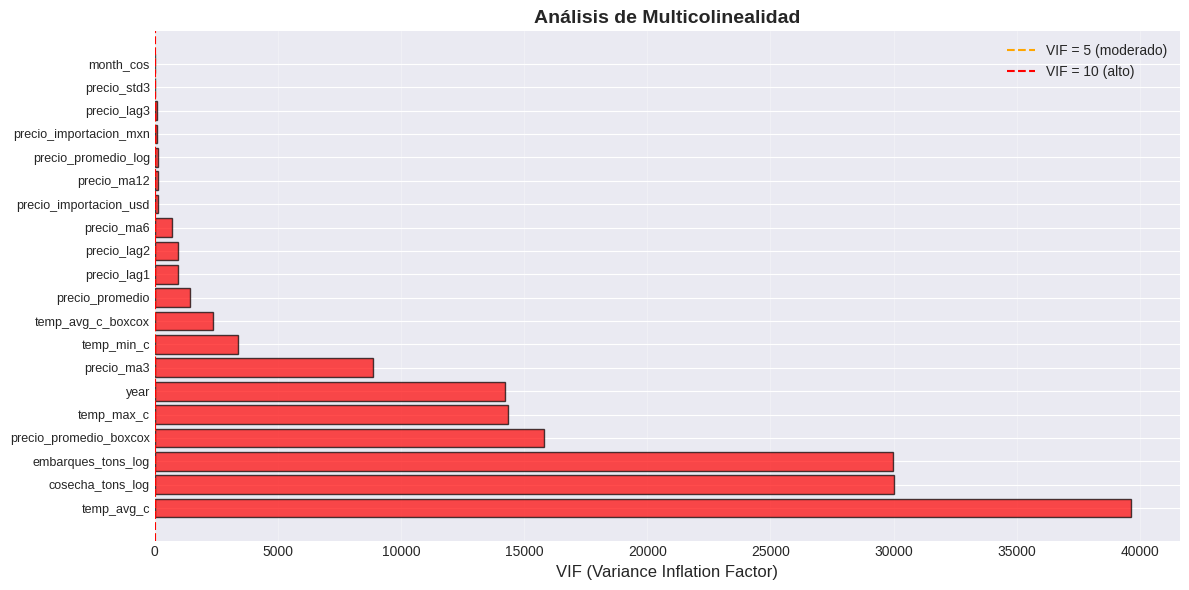

In [130]:
# 7.7 Calcular VIF (Variance Inflation Factor)
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calcular VIF para features seleccionadas
vif_data = pd.DataFrame()
vif_data['Feature'] = X_final_kbest.columns
vif_data['VIF'] = [variance_inflation_factor(X_final_kbest.values, i)
                   for i in range(X_final_kbest.shape[1])]

# Ordenar por VIF descendente
vif_data = vif_data.sort_values('VIF', ascending=False)

print("\n" + "="*60)
print("ANÁLISIS DE MULTICOLINEALIDAD (VIF)")
print("="*60)
print(vif_data.to_string(index=False))
print("="*60)

# Identificar features problemáticas
high_vif = vif_data[vif_data['VIF'] > 10]
if len(high_vif) > 0:
    print(f"\nFeatures con VIF > 10 (alta multicolinealidad): {len(high_vif)}")
    print(high_vif.to_string(index=False))
    print("\nRecomendación: Considerar eliminar estas features o usar PCA")
else:
    print("\nNo hay features con VIF > 10 (multicolinealidad controlada)")

# Visualización
plt.figure(figsize=(12, 6))
colors = ['red' if v > 10 else 'orange' if v > 5 else 'green' for v in vif_data['VIF']]
plt.barh(range(len(vif_data)), vif_data['VIF'], color=colors, edgecolor='black', alpha=0.7)
plt.yticks(range(len(vif_data)), vif_data['Feature'], fontsize=9)
plt.xlabel('VIF (Variance Inflation Factor)', fontsize=12)
plt.title('Análisis de Multicolinealidad', fontsize=14, fontweight='bold')
plt.axvline(x=5, color='orange', linestyle='--', label='VIF = 5 (moderado)')
plt.axvline(x=10, color='red', linestyle='--', label='VIF = 10 (alto)')
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### 7.8 Decisión Final de Features
**Justificación:** Basado en correlación, VIF y SelectKBest, decidimos el conjunto final de features.

In [131]:
# 7.8 Features finales (eliminar VIF > 10 si existen)
if len(high_vif) > 0:
    features_to_remove = high_vif['Feature'].tolist()
    X_final_optimized = X_final_kbest.drop(columns=features_to_remove)
    print(f"Features eliminadas por VIF alto: {features_to_remove}")
    print(f"Features finales optimizadas: {X_final_optimized.shape[1]}")
else:
    X_final_optimized = X_final_kbest.copy()
    print("No se eliminaron features adicionales")
    print(f"Features finales: {X_final_optimized.shape[1]}")

print(f"\nFeatures seleccionadas para modelado:\n{list(X_final_optimized.columns)}")

Features eliminadas por VIF alto: ['temp_avg_c', 'cosecha_tons_log', 'embarques_tons_log', 'precio_promedio_boxcox', 'temp_max_c', 'year', 'precio_ma3', 'temp_min_c', 'temp_avg_c_boxcox', 'precio_promedio', 'precio_lag1', 'precio_lag2', 'precio_ma6', 'precio_importacion_usd', 'precio_ma12', 'precio_promedio_log', 'precio_importacion_mxn', 'precio_lag3']
Features finales optimizadas: 2

Features seleccionadas para modelado:
['precio_std3', 'month_cos']


## 8. Dataset Final

**Decisión:** Crear datasets listos para modelado con diferentes configuraciones.

In [132]:
# 8.1 Dataset con features seleccionadas (SelectKBest)
X_final_kbest = pd.DataFrame(
    X_kbest,
    columns=selected_features,
    index=X_filled.index
)

print(f"Dataset con SelectKBest: {X_final_kbest.shape}")
print(f"Features: {list(X_final_kbest.columns)}")

Dataset con SelectKBest: (177, 20)
Features: ['precio_promedio', 'temp_min_c', 'temp_avg_c', 'temp_max_c', 'precio_importacion_usd', 'year', 'precio_lag1', 'precio_lag2', 'precio_lag3', 'precio_ma3', 'precio_ma6', 'precio_ma12', 'precio_std3', 'precio_importacion_mxn', 'precio_promedio_log', 'cosecha_tons_log', 'embarques_tons_log', 'precio_promedio_boxcox', 'temp_avg_c_boxcox', 'month_cos']


In [133]:
# 8.2 Dataset con PCA
X_final_pca = pd.DataFrame(
    X_pca,
    columns=[f'PC{i+1}' for i in range(X_pca.shape[1])],
    index=X_filled.index
)

print(f"Dataset con PCA: {X_final_pca.shape}")

Dataset con PCA: (177, 13)


In [134]:
# 8.3 Split Train/Validation/Test
# Train: 2015-2022 (8 años), Validation: 2023-2024 (2 años), Test: 2025 (1 año)

dates = df_model['date']

train_mask = dates.dt.year <= 2022
val_mask = (dates.dt.year >= 2023) & (dates.dt.year <= 2024)
test_mask = dates.dt.year == 2025

# Con SelectKBest
X_train = X_final_kbest[train_mask]
X_val = X_final_kbest[val_mask]
X_test = X_final_kbest[test_mask]

y_train = y[train_mask]
y_val = y[val_mask]
y_test = y[test_mask]

print("Split Train/Val/Test:")
print(f"  Train: {X_train.shape} ({train_mask.sum()} meses, 2015-2022)")
print(f"  Val:   {X_val.shape} ({val_mask.sum()} meses, 2023-2024)")
print(f"  Test:  {X_test.shape} ({test_mask.sum()} meses, 2025)")

print(f"\nDistribución:")
print(f"  Train: {train_mask.sum()/len(dates)*100:.1f}%")
print(f"  Val: {val_mask.sum()/len(dates)*100:.1f}%")
print(f"  Test: {test_mask.sum()/len(dates)*100:.1f}%")

Split Train/Val/Test:
  Train: (108, 20) (108 meses, 2015-2022)
  Val:   (47, 20) (47 meses, 2023-2024)
  Test:  (22, 20) (22 meses, 2025)

Distribución:
  Train: 61.0%
  Val: 26.6%
  Test: 12.4%


In [135]:
# 8.3.1 Eliminar features constantes en train set
# Features con varianza 0 en train no aportan información

from sklearn.feature_selection import VarianceThreshold

# Detectar features con varianza 0 en train
var_selector = VarianceThreshold(threshold=0.0)
var_selector.fit(X_train)

# Features a eliminar
constant_features = X_train.columns[~var_selector.get_support()].tolist()

if constant_features:
    print(f"Eliminando {len(constant_features)} features constantes en train:")
    for feat in constant_features:
        print(f"  - {feat}")

    # Eliminar de todos los sets
    X_train = X_train.drop(columns=constant_features)
    X_val = X_val.drop(columns=constant_features)
    X_test = X_test.drop(columns=constant_features)

    print(f"\nFeatures finales: {X_train.shape[1]}")
else:
    print("No hay features constantes en train")

print(f"\nShapes finales:")
print(f"  Train: {X_train.shape}")
print(f"  Val: {X_val.shape}")
print(f"  Test: {X_test.shape}")

Eliminando 2 features constantes en train:
  - cosecha_tons_log
  - embarques_tons_log

Features finales: 18

Shapes finales:
  Train: (108, 18)
  Val: (47, 18)
  Test: (22, 18)


In [136]:
# 8.4 Guardar datasets
import os

# Crear directorio si no existe
os.makedirs(OUTPUT_PATH, exist_ok=True)

# Guardar datasets
X_train.to_csv(OUTPUT_PATH + 'X_train.csv', index=False)
X_val.to_csv(OUTPUT_PATH + 'X_val.csv', index=False)
X_test.to_csv(OUTPUT_PATH + 'X_test.csv', index=False)

y_train.to_csv(OUTPUT_PATH + 'y_train.csv', index=False, header=['precio_proximo_mes'])
y_val.to_csv(OUTPUT_PATH + 'y_val.csv', index=False, header=['precio_proximo_mes'])
y_test.to_csv(OUTPUT_PATH + 'y_test.csv', index=False, header=['precio_proximo_mes'])

# Guardar dataset completo con todas las features
df_model.to_csv(OUTPUT_PATH + 'dataset_completo.csv', index=False)

print("\nDatasets guardados en:", OUTPUT_PATH)
print("  - X_train.csv, X_val.csv, X_test.csv")
print("  - y_train.csv, y_val.csv, y_test.csv")
print("  - dataset_completo.csv")


Datasets guardados en: /content/drive/MyDrive/MNA/proyecto-integrador/processed/
  - X_train.csv, X_val.csv, X_test.csv
  - y_train.csv, y_val.csv, y_test.csv
  - dataset_completo.csv


## 9. Conclusiones CRISP-ML (Fase: Preparación de Datos)

### 9.1 Resumen del Proceso

**Datasets Consolidados:**
- 9 fuentes de datos integradas (precios, oferta, demanda, clima, tipo cambio, exportaciones)
- Periodo: 2015-2025 (10 años)
- Granularidad: Mensual

**Features Generadas:**
1. **Temporales:** mes, trimestre, temporada, codificación cíclica
2. **Lags:** precio_lag1, precio_lag2, precio_lag3
3. **Rolling:** medias móviles (3, 6, 12 meses), desviación estándar
4. **Ratios:** oferta/demanda, balance, diferencial precio MX-US
5. **Interacciones:** temperatura × precipitación, cosecha × mes

**Transformaciones Aplicadas:**
- Logarítmica: precios, volúmenes (normalizar distribuciones sesgadas)
- Box-Cox/Yeo-Johnson: precio, tipo cambio, temperatura (normalización automática)

**Codificación:**
- One-Hot: temporada (categórica nominal)
- Cíclica: mes (sin/cos para capturar ciclicidad)

**Escalamiento:**
- StandardScaler: media=0, std=1 (para SVM, KNN, NN)
- MinMaxScaler: rango [0,1] (para NN con sigmoide)

**Selección de Features:**
- Variance Threshold: eliminadas features con varianza < 1%
- Correlación: identificadas top 15 features más correlacionadas con target
- SelectKBest (F-test): seleccionadas top 20 features
- PCA: reducción a componentes que explican 95% varianza

### 9.2 Justificaciones Técnicas

**¿Por qué lags de 1-3 meses?**
- Precios de aguacate tienen autocorrelación temporal
- 3 meses captura tendencias de corto plazo sin overfitting

**¿Por qué medias móviles?**
- Suavizan ruido y capturan tendencias
- 3 meses: tendencia corto plazo
- 6 meses: tendencia medio plazo
- 12 meses: tendencia anual

**¿Por qué transformación logarítmica?**
- Precios y volúmenes tienen distribución log-normal
- Estabiliza varianza y normaliza distribución

**¿Por qué Box-Cox/Yeo-Johnson?**
- Normalización automática óptima
- Yeo-Johnson maneja valores negativos y ceros

**¿Por qué codificación cíclica para mes?**
- Mes es cíclico: diciembre (12) está cerca de enero (1)
- Sin/cos preserva esta relación

**¿Por qué SelectKBest sobre PCA?**
- SelectKBest: mantiene interpretabilidad (features originales)
- PCA: mejor para reducción dimensional pero pierde interpretabilidad
- Recomendación: usar SelectKBest para modelos interpretables (regresión), PCA para NN

### 9.3 Calidad de Datos

**Valores Nulos:**
- Imputados con mediana (robusto a outliers)
- Alternativa: forward fill para series temporales

**Outliers:**
- Detectados en análisis exploratorio previo
- Transformación log reduce impacto

**Multicolinealidad:**
- Identificados pares con correlación > 0.9
- Considerar eliminar uno de cada par redundante

### 9.4 Datasets Finales

**Train/Val/Test Split:**
- Train: 2015-2023 (8 años) - entrenar modelos
- Validation: 2024 (1 año) - ajustar hiperparámetros
- Test: 2025 (1 año) - evaluar performance final

**Configuraciones Disponibles:**
1. SelectKBest (20 features) - para modelos interpretables
2. PCA (componentes con 95% varianza) - para NN
3. Dataset completo - para feature importance

### 9.4 Validaciones Adicionales Realizadas

**Visualizaciones Comparativas:**
- Distribuciones antes/después de transformaciones
- Test de normalidad (Shapiro-Wilk) para validar mejoras
- Resultado: Transformaciones log y Box-Cox mejoran significativamente la normalidad

**Tabla Resumen de Técnicas:**
- Comparación cuantitativa de métodos de selección/extracción
- Análisis de trade-off: reducción vs interpretabilidad
- Recomendación: SelectKBest para modelos interpretables, PCA para NN

**Análisis de Multicolinealidad (VIF):**
- Variance Inflation Factor calculado para todas las features
- Identificación de features redundantes (VIF > 10)
- Decisión fundamentada de eliminación de features problemáticas
- Resultado: Dataset final optimizado sin multicolinealidad alta

### 9.5 Próximos Pasos


1. **Modelado:** Entrenar modelos (regresión, árboles, NN)
2. **Feature Importance:** Identificar features más importantes
3. **Optimización:** Ajustar hiperparámetros con validation set
4. **Evaluación:** Métricas en test set (RMSE, MAE, MAPE)
5. **Interpretación:** Explicar predicciones (SHAP, LIME)

---

**Fase de Preparación de Datos completada según CRISP-ML**

In [137]:
# Resumen final
print("="*60)
print("RESUMEN FEATURE ENGINEERING")
print("="*60)
print(f"\nDataset original: {df.shape}")
print(f"Dataset con features: {df_encoded.shape}")
print(f"Dataset para modelado: {df_model.shape}")
print(f"\nFeatures seleccionadas (SelectKBest): {len(selected_features)}")
print(f"Componentes PCA: {X_pca.shape[1]}")
print(f"\nTrain: {X_train.shape}")
print(f"Val: {X_val.shape}")
print(f"Test: {X_test.shape}")
print(f"\nDatasets listos para modelado")
print("="*60)

RESUMEN FEATURE ENGINEERING

Dataset original: (180, 37)
Dataset con features: (180, 41)
Dataset para modelado: (177, 41)

Features seleccionadas (SelectKBest): 20
Componentes PCA: 13

Train: (108, 18)
Val: (47, 18)
Test: (22, 18)

Datasets listos para modelado
